#### here we try to generate all the plots from the stat files

In [11]:
import pandas as pd
import numpy as np
import pylab as pl
from astropy import units as u
from astropy.coordinates import SkyCoord

from matplotlib import pyplot as plt

#### Stable numbers above threshold and error function

In [12]:
def error_function(n1, n2):
    
    p = n1/(n1+n2)
    n = n1 + n2
    
    return np.sqrt(p*(1.0-p)/n)

def stable_hist_th(bins, hist_tp, hist_fp, hist_fn, threshold, verbose=False):

    hist_precision = []
    hist_err_precision = []
    
    hist_recall = []
    hist_err_recall = []
    
    bins_snr = []
    
    tp_st = 0
    fp_st = 0
    fn_st = 0
    
    last_con = 0
    bins_con = 0
    
    first = True
    
    for con in range(len(hist_tp)):

        tp_st = tp_st + hist_tp[con]
        fp_st = fp_st + hist_fp[con]
        fn_st = fn_st + hist_fn[con]
        
        #we require enough statistics to compute precision and recall
        #and then we restart
        #if (tp_st >= threshold or fp_st > threshold or fn_st > threshold):
        if (tp_st >= threshold):
            
            precision = 0
            recall = 0
            
            err_precision = 0
            err_recall = 0
            
            if ((tp_st + fp_st) > 0):
                precision = tp_st/(tp_st + fp_st)
                err_precision = error_function(tp_st, fp_st)
            
            if ((tp_st + fn_st) > 0):
                recall = tp_st/(tp_st + fn_st)
                err_recall = error_function(tp_st, fn_st)
                
            if verbose:
                if first:
                    print("\nHistogram Info\n")
                    print("Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com")
                    first = False
               
                print("%.2E, %.0f, %.0f, %.0f, %.2f, %.2f, %.2f, %.2f"%(bins[con],tp_st,fp_st,fn_st, precision, err_precision, recall, err_recall))
            
            bins_snr.append(bins[con])
                    
            hist_precision.append(precision)
            hist_err_precision.append(err_precision)
            
            hist_recall.append(recall)
            hist_err_recall.append(err_recall)
        
            tp_st = 0
            fp_st = 0
            fn_st = 0
            
            last_con = con
    
    return bins_snr, hist_precision, hist_recall, hist_err_precision, hist_err_recall

#### plot24_S10

In [3]:
def plot24_S10(path_to_stat_1, model, vthreshold):  
    
    stat_data = pd.read_csv(f"{path_to_stat_1}")
    
    #flux list
    
    #TP plus FN
    condition_1 = (((stat_data["stat_code"] == 0) | (stat_data["stat_code"] == 2)))
    #TP
    condition_2 = ((stat_data["stat_code"] == 0))
    
    #TP plus FN
    #condition_1 = (((stat_data["stat_code"] == 0) | (stat_data["stat_code"] == 2)))
    #TP plus FP
    condition_3 = ((stat_data["stat_code"] == 0) | (stat_data["stat_code"] == 1))
    
    tpfn_flux = stat_data.loc[condition_1, "test_flux_1000"]
    tp_flux   = stat_data.loc[condition_2, "test_flux_1000"]
    tpfp_flux = stat_data.loc[condition_3, "test_flux_1000"]
    
    #GLL list
    gll_flux = fermi_flux1000_list
    
    #bins are defined by hand
    bins=np.logspace(np.log10(1e-12),np.log10(1e-7), 20)
    
    ntpfn = tpfn_flux.shape[0]
    ntp   = tp_flux.shape[0]
    ntpfp = tpfp_flux.shape[0]
        
    ngll = gll_flux.shape[0]
    
    bins_med = []
    for con in range(len(bins)-1):
        bins_med.append(1.15*bins[con])
        
    #histograms
    return_values_tpfn, _  = np.histogram(tpfn_flux, bins=bins)   
    return_values_tp, _    = np.histogram(tp_flux, bins=bins)
    return_values_tpfp, _    = np.histogram(tpfp_flux, bins=bins)
    
    return_values_gll, _   = np.histogram(gll_flux, bins=bins)   
        
    fig, ax = plt.subplots(1, figsize=(5, 5))

    ax.set_xscale('log')
    ax.set_yscale('log')

    #scatter plots from histograms   
    
    ax.hist(gll_flux, bins = bins, alpha=0.5, label=f"gll-psc-v23 ({ngll} srcs)", color="grey")
    
    ax.scatter(bins_med, return_values_tpfn, c='r', alpha=1.0, marker='o', \
               label=f"F0-B1 ({ntpfn} true srcs)")
    
    ax.scatter(bins_med, return_values_tpfp, c='black', alpha=1.0, marker='o', \
               label=f"{model} ({ntpfp} TP+FP srcs)")
    
    ax.scatter(bins_med, return_values_tp, c='darkblue', alpha=1.0, marker='o', \
               label=f"{model} ({ntp} TP srcs)")
    
    #ax.scatter(bins_med, return_values_gll, c='gray', alpha=0.5, marker='o', \
    #           label=f"gll-psc-v23 ({ngll} srcs)")
    
    #fancy stuff
    ax.legend(loc='upper right', fontsize='medium')
    
    ax.set_ylim(0.5, 4e4)
    ax.set_xlim(1e-12, 2e-7)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)

    ax.set_ylabel("Source number counts", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    
    ax.axvline(vthreshold[0], lw=0.8, color="blue")
    ax.axvline(vthreshold[1], lw=0.8, color="black", ls="--")

    plt.show()
    
    return 0

In [4]:
def hist_S10(path_to_stat, lat_th, stat_th, verbose=False):
    stat_data  = pd.read_csv(f"{path_to_stat}")
    
    condition_tp = ((stat_data["stat_code"] == 0) & (abs(stat_data["test_lat"]) > lat_th))
    condition_fp = ((stat_data["stat_code"] == 1) & (abs(stat_data["test_lat"]) > lat_th))
    condition_fn = ((stat_data["stat_code"] == 2) & (abs(stat_data["test_lat"]) > lat_th))
    
    stat_data_tp_flux = np.array(stat_data.loc[condition_tp, "test_flux_10000"])
    stat_data_fp_flux = np.array(stat_data.loc[condition_fp, "test_flux_10000"])
    stat_data_fn_flux = np.array(stat_data.loc[condition_fn, "test_flux_10000"])
    
    stat_data_tp_flux = np.abs(stat_data_tp_flux)
    stat_data_fp_flux = np.abs(stat_data_fp_flux)
    stat_data_fn_flux = np.abs(stat_data_fn_flux)
    
    #default histograms 
    bins = np.logspace(np.log10(1e-14),np.log10(1e-9), 24)
          
    ht_tp_flux, _ = np.histogram(stat_data_tp_flux, bins=bins)
    ht_fp_flux, _ = np.histogram(stat_data_fp_flux, bins=bins)
    ht_fn_flux, _ = np.histogram(stat_data_fn_flux, bins=bins)
    
    #histograms with stable metrics results
    bins_flux, ht_pre_flux, ht_rec_flux, ht_err_pre, ht_err_rec = stable_hist_th(bins, ht_tp_flux, ht_fp_flux, ht_fn_flux, stat_th, verbose) 

    return bins_flux, ht_pre_flux, ht_rec_flux, ht_err_pre, ht_err_rec
    

def plot_metrics_flux_S10_latabove(path_to_stat, legend_loc, legend, lat_th, stat_th, vthreshold):
        
    #histograms with stable metrics results
    bins_flux_1, hist_precision_flux_1, hist_recall_flux_1, ht_err_pre_1, ht_err_rec_1 = hist_S10(path_to_stat[0], lat_th, stat_th, False) 
        
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_recall_flux_1, label=f"{legend[0]}", color="red")
    ax.plot(bins_flux_1, hist_recall_flux_1, '-o', color="red")
    ax.errorbar(bins_flux_1, hist_recall_flux_1, ht_err_rec_1, color="red", ls='none')
    
    #ax.scatter(bins_flux_2, hist_recall_flux_2, label=f"{legend[1]}", color="blue")
    #ax.plot(bins_flux_2, hist_recall_flux_2, '-o', color="blue")
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.2, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-9)
    ax.set_xticks([1e-12, 1e-12, 1e-11, 1e-10, 1e-9])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"$S_{10}$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    ax.axvline(4e-11, color="black", lw=0.8, ls="--")
    ax.text(1.5e-10, 0.8, f"|b| > {lat_th}°", fontsize=14)
    ax.text(4.2e-11, 0.4, f"4FGL flux threshold\nfor efficiency"+r"$\rightarrow$ 1", fontsize=12)
    plt.show()   
    
    return 0

In [5]:
def hist_S1_latabove(path_to_stat, lat_th, stat_th, verbose=False):
    ###########################################################################################
    #Read files
    ##########################################################################################
       
    stat_data = pd.read_csv(f"{path_to_stat}")
           
    ############################################################################################    
        
    condition_tp = ((stat_data["stat_code"] == 0) & (abs(stat_data["test_lat"]) > lat_th))
    condition_fp = ((stat_data["stat_code"] == 1) & (abs(stat_data["test_lat"]) > lat_th))
    condition_fn = ((stat_data["stat_code"] == 2) & (abs(stat_data["test_lat"]) > lat_th))
    
    ############################################################################################
    
    stat_data_tp_flux = np.array(stat_data.loc[condition_tp, "test_flux_1000"])
    stat_data_fp_flux = np.array(stat_data.loc[condition_fp, "test_flux_1000"])
    stat_data_fn_flux = np.array(stat_data.loc[condition_fn, "test_flux_1000"])
    
    #############################################################################################
    
    stat_data_tp_flux = np.abs(stat_data_tp_flux)
    stat_data_fp_flux = np.abs(stat_data_fp_flux)
    stat_data_fn_flux = np.abs(stat_data_fn_flux)
    
    #############################################################################################
    
    bins=np.logspace(np.log10(1e-12),np.log10(1e-7), 20)
    
    ht_tp_flux, _ = np.histogram(stat_data_tp_flux, bins=bins)
    ht_fp_flux, _ = np.histogram(stat_data_fp_flux, bins=bins)
    ht_fn_flux, _ = np.histogram(stat_data_fn_flux, bins=bins)
        
    #histograms with stable metrics results
    
    #print("F0_B4, precision, recall")
    bins_flux, ht_pre_flux, ht_rec_flux, ht_err_pre, ht_err_rec = stable_hist_th(bins, ht_tp_flux, ht_fp_flux, ht_fn_flux, stat_th, verbose)

    return bins_flux, ht_pre_flux, ht_rec_flux, ht_err_pre, ht_err_rec


def plot_metrics_flux_S1_latabove(path_to_stat, legend_loc, legend, lat_th, stat_th, vthreshold):
    
    bins_flux_1, hist_precision_flux_1, hist_recall_flux_1, ht_err_pre_1, ht_err_rec_1 = hist_S1_latabove(path_to_stat[0], lat_th, stat_th, True)
    bins_flux_2, hist_precision_flux_2, hist_recall_flux_2, ht_err_pre_2, ht_err_rec_2 = hist_S1_latabove(path_to_stat[1], lat_th, stat_th, False)
    bins_flux_3, hist_precision_flux_3, hist_recall_flux_3, ht_err_pre_3, ht_err_rec_3 = hist_S1_latabove(path_to_stat[2], lat_th, stat_th, False)
    
    bins_flux_4, hist_precision_flux_4, hist_recall_flux_4, ht_err_pre_4, ht_err_rec_4 = hist_S1_latabove(path_to_stat[3], lat_th, stat_th, True)
    bins_flux_5, hist_precision_flux_5, hist_recall_flux_5, ht_err_pre_5, ht_err_rec_5 = hist_S1_latabove(path_to_stat[4], lat_th, stat_th, False)
    bins_flux_6, hist_precision_flux_6, hist_recall_flux_6, ht_err_pre_6, ht_err_rec_6 = hist_S1_latabove(path_to_stat[5], lat_th, stat_th, False)
    
    ##########################################################################################
    #smearing by hand. always trying to be conservative
    ##########################################################################################
    
    ##########################################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_precision_flux_1, color="red")
    ax.plot(bins_flux_1, hist_precision_flux_1, '-o', label=legend[0], color="red")
    ax.errorbar(bins_flux_1, hist_precision_flux_1, ht_err_pre_1, color="red", ls='none') 
    
    ax.scatter(bins_flux_2, hist_precision_flux_2, color="red")
    ax.plot(bins_flux_2, hist_precision_flux_2, '--o', label=legend[1], color="red")
    ax.errorbar(bins_flux_2, hist_precision_flux_2, ht_err_pre_2, color="red", ls='none') 
    
    ax.scatter(bins_flux_3, hist_precision_flux_3, color="red")
    ax.plot(bins_flux_3, hist_precision_flux_3, ':o', label=legend[2], color="red")
    ax.errorbar(bins_flux_3, hist_precision_flux_3, ht_err_pre_3, color="red", ls='none') 
    
    #cnet
    ax.scatter(bins_flux_4, hist_precision_flux_4, color="black")
    ax.plot(bins_flux_4, hist_precision_flux_4, '-o', label=legend[3], color="black")
    ax.errorbar(bins_flux_4, hist_precision_flux_4, ht_err_pre_4, color="black", ls='none') 
    
    ax.scatter(bins_flux_5, hist_precision_flux_5, color="black")
    ax.plot(bins_flux_5, hist_precision_flux_5, '--o', label=legend[4], color="black")
    ax.errorbar(bins_flux_5, hist_precision_flux_5, ht_err_pre_5, color="black", ls='none') 
    
    ax.scatter(bins_flux_6, hist_precision_flux_6, color="black")
    ax.plot(bins_flux_6, hist_precision_flux_6, ':o', label=legend[5], color="black")
    ax.errorbar(bins_flux_6, hist_precision_flux_6, ht_err_pre_6, color="black", ls='none') 
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| > {lat_th}°", fontsize=14)
    
    plt.show() 
    ####################################################################################3
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_recall_flux_1, color="red")
    ax.plot(bins_flux_1, hist_recall_flux_1, '-o', label=legend[0], color="red")
    ax.errorbar(bins_flux_1, hist_recall_flux_1, ht_err_rec_1, color="red", ls='none') 
    
    ax.scatter(bins_flux_2, hist_recall_flux_2, color="red")
    ax.plot(bins_flux_2, hist_recall_flux_2, '--o', label=legend[1], color="red")
    ax.errorbar(bins_flux_2, hist_recall_flux_2, ht_err_rec_2, color="red", ls='none') 
    
    ax.scatter(bins_flux_3, hist_recall_flux_3, color="red")
    ax.plot(bins_flux_3, hist_recall_flux_3, ':o', label=legend[2], color="red")
    ax.errorbar(bins_flux_3, hist_recall_flux_3, ht_err_rec_3, color="red", ls='none') 
    
    #cnet
    ax.scatter(bins_flux_4, hist_recall_flux_4, color="black")
    ax.plot(bins_flux_4, hist_recall_flux_4, '-o', label=legend[3], color="black")
    ax.errorbar(bins_flux_4, hist_recall_flux_4, ht_err_rec_4, color="black", ls='none') 
    
    ax.scatter(bins_flux_5, hist_recall_flux_5, color="black")
    ax.plot(bins_flux_5, hist_recall_flux_5, '--o', label=legend[4], color="black")
    ax.errorbar(bins_flux_5, hist_recall_flux_5, ht_err_rec_5, color="black", ls='none') 
    
    ax.scatter(bins_flux_6, hist_recall_flux_6, color="black")
    ax.plot(bins_flux_6, hist_recall_flux_6, ':o', label=legend[5], color="black")
    ax.errorbar(bins_flux_6, hist_recall_flux_6, ht_err_rec_6, color="black", ls='none') 
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   
    
    return 0

In [6]:
def hist_S1_latbelow(path_to_stat, lat_th, stat_th, verbose):
    
    ########################################
    stat_data  = pd.read_csv(f"{path_to_stat}")
    
    ########################################
    condition_tp = ((stat_data["stat_code"] == 0) & (abs(stat_data["test_lat"]) < lat_th))
    condition_fp = ((stat_data["stat_code"] == 1) & (abs(stat_data["test_lat"]) < lat_th))
    condition_fn = ((stat_data["stat_code"] == 2) & (abs(stat_data["test_lat"]) < lat_th))
    
    ########################################
    stat_data_tp_flux = np.array(stat_data.loc[condition_tp, "test_flux_1000"])
    stat_data_fp_flux = np.array(stat_data.loc[condition_fp, "test_flux_1000"])
    stat_data_fn_flux = np.array(stat_data.loc[condition_fn, "test_flux_1000"])
    
    ###########################################################
    stat_data_tp_flux = np.abs(stat_data_tp_flux)
    stat_data_fp_flux = np.abs(stat_data_fp_flux)
    stat_data_fn_flux = np.abs(stat_data_fn_flux)
    
    ###########################################################
    bins=np.logspace(np.log10(1e-12),np.log10(1e-7), 20)
      
    ht_tp_flux, _ = np.histogram(stat_data_tp_flux, bins=bins)
    ht_fp_flux, _ = np.histogram(stat_data_fp_flux, bins=bins)
    ht_fn_flux, _ = np.histogram(stat_data_fn_flux, bins=bins)
    
    #####################################################################
    
    #histograms with stable metrics results
    bins_flux, ht_pre_flux_1, ht_rec_flux, ht_err_pre, ht_err_rec = stable_hist_th(bins, ht_tp_flux, ht_fp_flux, ht_fn_flux, stat_th, verbose) 

    return bins_flux, ht_pre_flux_1, ht_rec_flux, ht_err_pre, ht_err_rec

def plot_metrics_flux_S1_latbelow(path_to_stat, legend_loc, legend, lat_th, stat_th, vthreshold):
       
    #histograms with stable metrics results
    bins_flux_1, hist_precision_flux_1, hist_recall_flux_1, ht_err_pre_1, ht_err_rec_1 = hist_S1_latbelow(path_to_stat[0], lat_th, stat_th, False)
    bins_flux_2, hist_precision_flux_2, hist_recall_flux_2, ht_err_pre_2, ht_err_rec_2 = hist_S1_latbelow(path_to_stat[1], lat_th, stat_th, False)
    bins_flux_3, hist_precision_flux_3, hist_recall_flux_3, ht_err_pre_3, ht_err_rec_3 = hist_S1_latbelow(path_to_stat[2], lat_th, stat_th, False)
    
    bins_flux_4, hist_precision_flux_4, hist_recall_flux_4, ht_err_pre_4, ht_err_rec_4 = hist_S1_latbelow(path_to_stat[3], lat_th, stat_th, False)
    bins_flux_5, hist_precision_flux_5, hist_recall_flux_5, ht_err_pre_5, ht_err_rec_5 = hist_S1_latbelow(path_to_stat[4], lat_th, stat_th, False)
    bins_flux_6, hist_precision_flux_6, hist_recall_flux_6, ht_err_pre_6, ht_err_rec_6 = hist_S1_latbelow(path_to_stat[5], lat_th, stat_th, False)

    #################################################################
    #smearing by hand. always trying to be conservative
    #################################################################
    hist_precision_flux_2[4] = 0
    hist_recall_flux_2[4] = 0
    ht_err_pre_2[4] = 0
    ht_err_rec_2[4] = 0
    
    hist_precision_flux_3[3] = 0
    hist_recall_flux_3[3] = 0
    ht_err_pre_3[3] = 0
    ht_err_rec_3[3] = 0
    #################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_precision_flux_1, color="red")
    ax.plot(bins_flux_1, hist_precision_flux_1, '-o', label=legend[0], color="red") 
    ax.errorbar(bins_flux_1, hist_precision_flux_1, ht_err_pre_1, color="red", ls='none') 
    
    ax.scatter(bins_flux_2, hist_precision_flux_2, color="red")
    ax.plot(bins_flux_2, hist_precision_flux_2, '--o', label=legend[1], color="red")
    ax.errorbar(bins_flux_2, hist_precision_flux_2, ht_err_pre_2, color="red", ls='none')
    
    ax.scatter(bins_flux_3, hist_precision_flux_3, color="red")
    ax.plot(bins_flux_3, hist_precision_flux_3, ':o', label=legend[2], color="red")
    ax.errorbar(bins_flux_3, hist_precision_flux_3, ht_err_pre_3, color="red", ls='none')
    
    #cnet
    ax.scatter(bins_flux_4, hist_precision_flux_4, color="black")
    ax.plot(bins_flux_4, hist_precision_flux_4, '-o', label=legend[3], color="black")
    ax.errorbar(bins_flux_4, hist_precision_flux_4, ht_err_pre_4, color="black", ls='none')
    
    ax.scatter(bins_flux_5, hist_precision_flux_5, color="black")
    ax.plot(bins_flux_5, hist_precision_flux_5, '--o', label=legend[4], color="black")
    ax.errorbar(bins_flux_5, hist_precision_flux_5, ht_err_pre_5, color="black", ls='none')
    
    ax.scatter(bins_flux_6, hist_precision_flux_6, color="black")
    ax.plot(bins_flux_6, hist_precision_flux_6, ':o', label=legend[5], color="black")
    ax.errorbar(bins_flux_6, hist_precision_flux_6, ht_err_pre_6, color="black", ls='none')
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| < {lat_th}°", fontsize=14)
    plt.show() 
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.scatter(bins_flux_1, hist_recall_flux_1, color="red")
    ax.plot(bins_flux_1, hist_recall_flux_1, '-o', label=legend[0], color="red")
    ax.errorbar(bins_flux_1, hist_recall_flux_1, ht_err_rec_1, color="red", ls='none')
    
    ax.scatter(bins_flux_2, hist_recall_flux_2, color="red")
    ax.plot(bins_flux_2, hist_recall_flux_2, '--o', label=legend[1], color="red")
    ax.errorbar(bins_flux_2, hist_recall_flux_2, ht_err_rec_2, color="red", ls='none')
    
    ax.scatter(bins_flux_3, hist_recall_flux_3, color="red")
    ax.plot(bins_flux_3, hist_recall_flux_3, ':o', label=legend[2], color="red")
    ax.errorbar(bins_flux_3, hist_recall_flux_3, ht_err_rec_3, color="red", ls='none')
    
    #cnet
    ax.scatter(bins_flux_4, hist_recall_flux_4, color="black")
    ax.plot(bins_flux_4, hist_recall_flux_4, '-o', label=legend[3], color="black")
    ax.errorbar(bins_flux_4, hist_recall_flux_4, ht_err_rec_4, color="black", ls='none')
    
    ax.scatter(bins_flux_5, hist_recall_flux_5, color="black")
    ax.plot(bins_flux_5, hist_recall_flux_5, '--o', label=legend[4], color="black")
    ax.errorbar(bins_flux_5, hist_recall_flux_5, ht_err_rec_5, color="black", ls='none')
    
    ax.scatter(bins_flux_6, hist_recall_flux_6, color="black")
    ax.plot(bins_flux_6, hist_recall_flux_6, ':o', label=legend[5], color="black")
    ax.errorbar(bins_flux_6, hist_recall_flux_6, ht_err_rec_6, color="black", ls='none')
    
    ax.legend(loc='lower right', fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-8)
    ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"$S_1$ [photons cm$^{-2}$ s$^{-1}$]", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    ax.text(2e-12, 1.0, f"|b| < {lat_th}°", fontsize=14)
    plt.show()   
    
    return 0

#### SNR all

In [7]:
def hist_snr_all(path_to_stat, stat_th, verbose):
    
    ##############################################################################
    #UNEK stat data
    ##############################################################################
    
    stat_data  = pd.read_csv(f"{path_to_stat}")
        
    condition_tp = ((stat_data["stat_code"] == 0))
    condition_fp = ((stat_data["stat_code"] == 1))
    condition_fn = ((stat_data["stat_code"] == 2))
    
    stat_data_tp = np.array(stat_data.loc[condition_tp, "snr_center_pred"])
    stat_data_fp = np.array(stat_data.loc[condition_fp, "snr_center_pred"])
    stat_data_fn = np.array(stat_data.loc[condition_fn, "snr_center_pred"])
    
    stat_data_tp = np.abs(stat_data_tp)
    stat_data_fp = np.abs(stat_data_fp)
    stat_data_fn = np.abs(stat_data_fn)
    
    ############################################################################
    bins = np.logspace(np.log10(1e-2),np.log10(100), 20)
    ############################################################################
          
    ############################################################################
    #UNEK histograms
    ############################################################################
        
    ht_tp, _ = np.histogram(stat_data_tp, bins=bins)
    ht_fp, _ = np.histogram(stat_data_fp, bins=bins)
    ht_fn, _ = np.histogram(stat_data_fn, bins=bins)
    
    #histograms with stable metrics results
    bins_snr, ht_pre, ht_rec, ht_err_pre, ht_err_rec = stable_hist_th(bins, ht_tp, ht_fp, ht_fn, stat_th, verbose) 
    
    return bins_snr, ht_pre, ht_rec, ht_err_pre, ht_err_rec

def plot_metrics_snr_all(path_to_stat, legend_loc, legend, stat_th, vthreshold):
    
    bins_snr_1, hist_precision_1, hist_recall_1, ht_err_pre_1, ht_err_rec_1 = hist_snr_all(path_to_stat[0], stat_th, True) 
    bins_snr_2, hist_precision_2, hist_recall_2, ht_err_pre_2, ht_err_rec_2 = hist_snr_all(path_to_stat[1], stat_th, True) 

    ###########################################################################
    #Plots
    ###########################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_snr_1, hist_precision_1, color="red")
    ax.plot(bins_snr_1, hist_precision_1, '-o', label=legend[0], color="red")
    ax.errorbar(bins_snr_1, hist_precision_1, ht_err_pre_1, color="red")
    
    ax.scatter(bins_snr_2, hist_precision_2, color="black")
    ax.plot(bins_snr_2, hist_precision_2, '-o', label=legend[1], color="black")
    ax.errorbar(bins_snr_2, hist_precision_2, ht_err_pre_2, color="black")
    
    ax.legend(loc=legend_loc, fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(3e-1, 70)
    ax.set_xticks([1, 10, 70])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"SNR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    #ax.text(0.2, 0.6, f"|b| > {lat_th}°", fontsize=14)
    plt.show() 
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_snr_1, hist_recall_1, color="red")
    ax.plot(bins_snr_1, hist_recall_1, '-o', label=legend[0], color="red")
    ax.errorbar(bins_snr_1, hist_recall_1, ht_err_rec_1, color="red")
    
    ax.scatter(bins_snr_2, hist_recall_2, color="black")
    ax.plot(bins_snr_2, hist_recall_2, '-o', label=legend[1], color="black")
    ax.errorbar(bins_snr_2, hist_recall_2, ht_err_rec_2, color="black")

    ax.legend(loc=legend_loc, fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    #ax.set_xlim(1e-2, 10)
    #ax.set_xticks([1e-2, 1e-1, 1, 10])
    ax.set_xlim(3e-1,70)
    ax.set_xticks([1, 10, 70])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"SNR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    #ax.text(0.2, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   

    return 0

In [8]:
def hist_sbr_all(path_to_stat, stat_th, verbose):
     
    stat_data  = pd.read_csv(f"{path_to_stat}")
        
    condition_tp = ((stat_data["stat_code"] == 0))
    condition_fp = ((stat_data["stat_code"] == 1))
    condition_fn = ((stat_data["stat_code"] == 2))
    
    stat_data_tp = np.array(stat_data.loc[condition_tp, "sbr_center_pred"])
    stat_data_fp = np.array(stat_data.loc[condition_fp, "sbr_center_pred"])
    stat_data_fn = np.array(stat_data.loc[condition_fn, "sbr_center_pred"])
    
    stat_data_tp = np.abs(stat_data_tp)
    stat_data_fp = np.abs(stat_data_fp)
    stat_data_fn = np.abs(stat_data_fn)
     
    ############################################################################
    bins = np.logspace(np.log10(1e-2),np.log10(100), 20)
    ############################################################################
        
    ht_tp, _ = np.histogram(stat_data_tp, bins=bins)
    ht_fp, _ = np.histogram(stat_data_fp, bins=bins)
    ht_fn, _ = np.histogram(stat_data_fn, bins=bins)
    
    #histograms with stable metrics results
    bins_snr, ht_pre, ht_rec, ht_err_pre, ht_err_rec = stable_hist_th(bins, ht_tp, ht_fp, ht_fn, stat_th, verbose) 
    
    return bins_snr, ht_pre, ht_rec, ht_err_pre, ht_err_rec

def plot_metrics_sbr_all(path_to_stat, legend_loc, legend, stat_th, vthreshold):
    
    bins_sbr_1, hist_precision_1, hist_recall_1, ht_err_pre_1, ht_err_rec_1 = hist_sbr_all(path_to_stat[0], stat_th, True)
    bins_sbr_2, hist_precision_2, hist_recall_2, ht_err_pre_2, ht_err_rec_2 = hist_sbr_all(path_to_stat[1], stat_th, True)
    
    ###########################################################################
    #Plots
    ###########################################################################
    
    #Precision
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_sbr_1, hist_precision_1, color="red")
    ax.plot(bins_sbr_1, hist_precision_1, '-o', label=legend[0], color="red")
    ax.errorbar(bins_sbr_1, hist_precision_1, ht_err_pre_1, color="red")
    
    ax.scatter(bins_sbr_2, hist_precision_2, color="black")
    ax.plot(bins_sbr_2, hist_precision_2, '-o', label=legend[1], color="black")
    ax.errorbar(bins_sbr_2, hist_precision_2, ht_err_pre_2, color="black")
        
    ax.legend(loc=legend_loc, fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    ax.set_xlim(2e-2, 50)
    ax.set_xticks([0.1, 1, 10])

    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Purity", fontsize=14)
    ax.set_xlabel(r"SBR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[0], lw=0.8)
    #ax.text(0.2, 0.6, f"|b| > {lat_th}°", fontsize=14)
    plt.show() 
    
    #Recall
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    #unek
    ax.scatter(bins_sbr_1, hist_recall_1, color="red")
    ax.plot(bins_sbr_1, hist_recall_1, '-o', label=legend[0], color="red")
    ax.errorbar(bins_sbr_1, hist_recall_1, ht_err_rec_1, color="red")
    
    ax.scatter(bins_sbr_2, hist_recall_2, color="blue")
    ax.plot(bins_sbr_2, hist_recall_2, '-o', label=legend[1], color="black")
    ax.errorbar(bins_sbr_2, hist_recall_2, ht_err_rec_2, color="black")
    
    ax.legend(loc=legend_loc, fontsize='large')
    
    ax.set_ylim(0.0, 1.1)
    
    ax.set_xscale('log')
    #ax.set_xlim(1e-2, 10)
    #ax.set_xticks([1e-2, 1e-1, 1, 10])
    ax.set_xlim(2e-2,50)
    ax.set_xticks([0.1, 1, 10])
    
    ax.tick_params(labelcolor='black', labelsize='large', width=3)
    ax.set_ylabel("Completness", fontsize=14)
    ax.set_xlabel(r"SBR$_c$", fontsize=14)
    #plt.grid(True)
    ax.axhline(0.9, lw=0.8)
    ax.axvline(vthreshold[1], lw=0.8)
    #ax.text(0.2, 1.0, f"|b| > {lat_th}°", fontsize=14)
    plt.show()   


    return 0

#### 4FGL files

In [13]:
path_to_data = "/home/bapanes/Research-Now/local/centroidnet-gr-local/data-solid"

In [14]:
PSR_df = pd.read_csv(f"{path_to_data}/utils/PSR_PLEC_FS.csv", sep=",")
AGN_df = pd.read_csv(f"{path_to_data}/utils/AGN_LP_FS.csv", sep=",")
fermi_flux1000_list = []
fermi_flux10000_list = []

for con in range(len(PSR_df)):
    fermi_flux1000_list.append(PSR_df["PLEC_F1000"].iloc[con])
    fermi_flux10000_list.append(PSR_df["PLEC_F10000"].iloc[con])
    
for con in range(len(AGN_df)):
    fermi_flux1000_list.append(AGN_df["LP_F1000"].iloc[con])
    fermi_flux10000_list.append(AGN_df["LP_F10000"].iloc[con])
    
fermi_flux1000_list = np.array(fermi_flux1000_list)
fermi_flux10000_list = np.array(fermi_flux10000_list)

print("PSRs and AGNsin gll_psc_v23: ", len(fermi_flux1000_list))

PSRs and AGNsin gll_psc_v23:  3762


#### The plot in the paper uses the file with overlapping removed

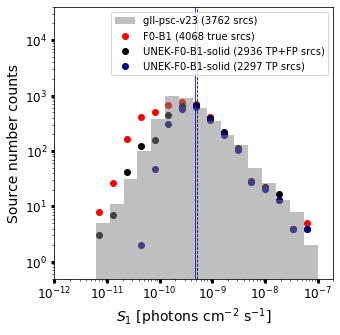

0

In [31]:
path_to_stat_after_ps_basis = f"{path_to_data}/results-unek-100k/unek_evaluation_f0_b1_solid_wb_ps_basis.csv"
plot24_S10(path_to_stat_after_ps_basis, "UNEK-F0-B1-solid", [4.7e-10, 5.2e-10])

#### Define the file paths

In [16]:
path_to_unek_stat_f0_b1 = f"{path_to_data}/results-unek-100k/unek_evaluation_f0_b1_solid.csv"
path_to_unek_stat_f0_b2 = f"{path_to_data}/results-unek-100k/unek_evaluation_f0_b2_solid.csv"
path_to_unek_stat_f0_b3 = f"{path_to_data}/results-unek-100k/unek_evaluation_f0_b3_solid.csv"

path_to_unek_stat_f1_b1 = f"{path_to_data}/results-unek-100k/unek_evaluation_f1_b1_solid.csv"
path_to_unek_stat_f2_b1 = f"{path_to_data}/results-unek-100k/unek_evaluation_f2_b1_solid.csv"

In [20]:
path_to_cnet = f"{path_to_data}/data-cnet/results-100k-new"

path_to_cnet_stat_f0_b1 = f"{path_to_cnet}/cnet_evaluation_F0_B1_b1_th1.csv"
path_to_cnet_stat_f0_b2 = f"{path_to_cnet}/cnet_evaluation_F0_B2_b1_th1.csv"
path_to_cnet_stat_f0_b3 = f"{path_to_cnet}/cnet_evaluation_F0_B3_b1_th1.csv"

path_to_cnet_stat_f1_b1 = f"{path_to_cnet}/cnet_evaluation_F1_B1_b1_th1.csv"
path_to_cnet_stat_f2_b1 = f"{path_to_cnet}/cnet_evaluation_F2_B1_b1_th1.csv"

#### F10000 or S10 plots

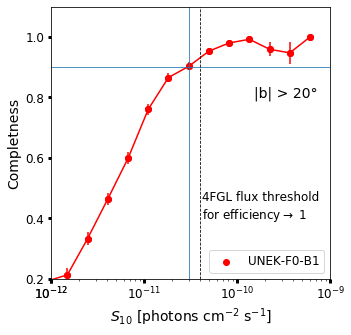

0

In [18]:
legend_loc = "best"

plot_metrics_flux_S10_latabove([path_to_unek_stat_f0_b1], legend_loc, 
                               [f"UNEK-F0-B1"], 20, 0,
                               vthreshold=[_, 3e-11])

#### F1000, lat > 20 deg

These are the plots with the same background B1 and different mock point sources F0, F1, F2, etc


Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
1.00E-12, 0, 0, 0, 0.00, 0.00, 0.00, 0.00
1.83E-12, 0, 0, 0, 0.00, 0.00, 0.00, 0.00
3.36E-12, 0, 0, 0, 0.00, 0.00, 0.00, 0.00
6.16E-12, 0, 2, 22, 0.00, 0.00, 0.00, 0.00
1.13E-11, 0, 5, 52, 0.00, 0.00, 0.00, 0.00
2.07E-11, 2, 32, 346, 0.06, 0.04, 0.01, 0.00
3.79E-11, 11, 106, 908, 0.09, 0.03, 0.01, 0.00
6.95E-11, 112, 113, 1014, 0.50, 0.03, 0.10, 0.01
1.27E-10, 605, 149, 909, 0.80, 0.01, 0.40, 0.01
2.34E-10, 1227, 127, 483, 0.91, 0.01, 0.72, 0.01
4.28E-10, 1336, 73, 179, 0.95, 0.01, 0.88, 0.01
7.85E-10, 800, 51, 75, 0.94, 0.01, 0.91, 0.01
1.44E-09, 427, 46, 29, 0.90, 0.01, 0.94, 0.01
2.64E-09, 215, 21, 11, 0.91, 0.02, 0.95, 0.01
4.83E-09, 77, 2, 1, 0.97, 0.02, 0.99, 0.01
8.86E-09, 47, 1, 1, 0.98, 0.02, 0.98, 0.02
1.62E-08, 23, 3, 0, 0.88, 0.06, 1.00, 0.00
2.98E-08, 8, 0, 0, 1.00, 0.00, 1.00, 0.00
5.46E-08, 9, 0, 0, 1.00, 0.00, 1.00, 0.00

Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
1.00E-1

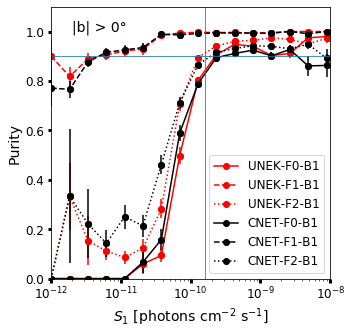

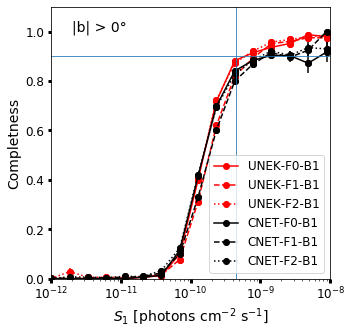

0

In [28]:
legend_loc = "best"

plot_metrics_flux_S1_latabove([path_to_unek_stat_f0_b1, path_to_unek_stat_f1_b1, path_to_unek_stat_f2_b1,
                               path_to_cnet_stat_f0_b1, path_to_cnet_stat_f1_b1, path_to_cnet_stat_f2_b1], 
                              legend_loc, 
                              [f"UNEK-F0-B1", f"UNEK-F1-B1", f"UNEK-F2-B1",
                               f"CNET-F0-B1", f"CNET-F1-B1", f"CNET-F2-B1"], 
                              0, 0,
                              vthreshold=[1.6e-10, 4.5e-10])


Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
1.00E-12, 0, 0, 0, 0.00, 0.00, 0.00, 0.00
1.83E-12, 0, 0, 0, 0.00, 0.00, 0.00, 0.00
3.36E-12, 0, 0, 0, 0.00, 0.00, 0.00, 0.00
6.16E-12, 0, 0, 14, 0.00, 0.00, 0.00, 0.00
1.13E-11, 0, 2, 23, 0.00, 0.00, 0.00, 0.00
2.07E-11, 2, 17, 198, 0.11, 0.07, 0.01, 0.01
3.79E-11, 9, 51, 524, 0.15, 0.05, 0.02, 0.01
6.95E-11, 95, 69, 588, 0.58, 0.04, 0.14, 0.01
1.27E-10, 498, 75, 428, 0.87, 0.01, 0.54, 0.02
2.34E-10, 904, 62, 128, 0.94, 0.01, 0.88, 0.01
4.28E-10, 944, 35, 31, 0.96, 0.01, 0.97, 0.01
7.85E-10, 479, 29, 14, 0.94, 0.01, 0.97, 0.01
1.44E-09, 217, 21, 8, 0.91, 0.02, 0.96, 0.01
2.64E-09, 99, 6, 3, 0.94, 0.02, 0.97, 0.02
4.83E-09, 30, 2, 1, 0.94, 0.04, 0.97, 0.03
8.86E-09, 2, 0, 0, 1.00, 0.00, 1.00, 0.00
1.62E-08, 9, 1, 0, 0.90, 0.09, 1.00, 0.00
2.98E-08, 2, 0, 0, 1.00, 0.00, 1.00, 0.00
5.46E-08, 0, 0, 0, 0.00, 0.00, 0.00, 0.00

Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
1.00E-12, 0, 0, 0, 0.00

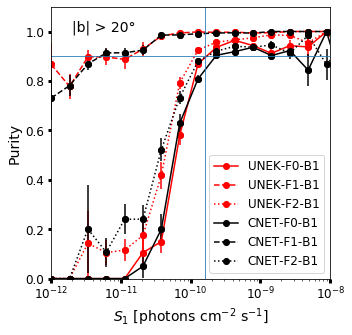

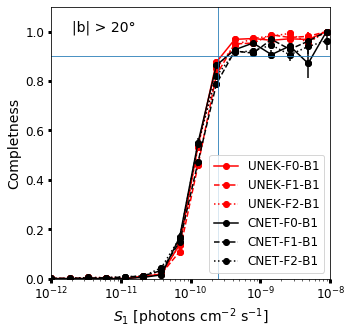

0

In [132]:
legend_loc = "best"

plot_metrics_flux_S1_latabove([path_to_unek_stat_f0_b1, path_to_unek_stat_f1_b1, path_to_unek_stat_f2_b1,
                               path_to_cnet_stat_f0_b1, path_to_cnet_stat_f1_b1, path_to_cnet_stat_f2_b1], 
                              legend_loc, 
                              [f"UNEK-F0-B1", f"UNEK-F1-B1", f"UNEK-F2-B1",
                               f"CNET-F0-B1", f"CNET-F1-B1", f"CNET-F2-B1"], 
                              20, 0,
                              vthreshold=[1.6e-10, 2.5e-10])

#### Notice that TP + FN is the same for UNEK and CNET because this number depends on the test set only

#### F1000 (S1), lat < 20 deg

These are the plots with the same mock catalog F0 and different background B1, B2, B3

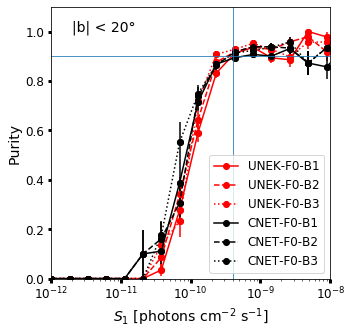

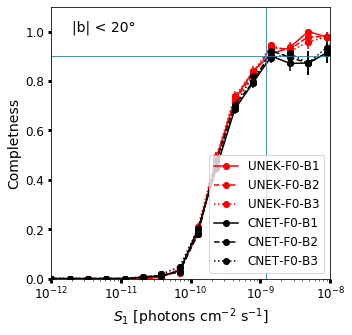

0

In [117]:
legend_loc = "best"

plot_metrics_flux_S1_latbelow([path_to_unek_stat_f0_b1, path_to_unek_stat_f0_b2, path_to_unek_stat_f0_b3,
                               path_to_cnet_stat_f0_b1, path_to_cnet_stat_f0_b2, path_to_cnet_stat_f0_b3], 
                              legend_loc, 
                              [f"UNEK-F0-B1", f"UNEK-F0-B2", f"UNEK-F0-B3",
                               f"CNET-F0-B1", f"CNET-F0-B2", f"CNET-F0-B3"], 
                              20, 0,
                              vthreshold=[4e-10, 1.2e-9])

#### SNR plots

These are the plots for the same F0_B1, but considering UNEK and CNET


Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
6.95E-02, 3, 240, 71, 0.01, 0.01, 0.04, 0.02
1.13E-01, 4, 28, 162, 0.12, 0.06, 0.02, 0.01
1.83E-01, 4, 21, 382, 0.16, 0.07, 0.01, 0.01
2.98E-01, 37, 31, 645, 0.54, 0.06, 0.05, 0.01
4.83E-01, 83, 34, 914, 0.71, 0.04, 0.08, 0.01
7.85E-01, 245, 73, 895, 0.77, 0.02, 0.21, 0.01
1.27E+00, 519, 63, 634, 0.89, 0.01, 0.45, 0.01
2.07E+00, 964, 60, 190, 0.94, 0.01, 0.84, 0.01
3.36E+00, 1102, 52, 93, 0.95, 0.01, 0.92, 0.01
5.46E+00, 879, 35, 33, 0.96, 0.01, 0.96, 0.01
8.86E+00, 530, 14, 8, 0.97, 0.01, 0.99, 0.01
1.44E+01, 329, 10, 3, 0.97, 0.01, 0.99, 0.01
2.34E+01, 138, 7, 0, 0.95, 0.02, 1.00, 0.00
3.79E+01, 52, 3, 1, 0.95, 0.03, 0.98, 0.02
6.16E+01, 19, 0, 0, 1.00, 0.00, 1.00, 0.00

Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
1.13E-01, 3, 143, 234, 0.02, 0.01, 0.01, 0.01
1.83E-01, 12, 21, 383, 0.36, 0.08, 0.03, 0.01
2.98E-01, 34, 42, 656, 0.45, 0.06, 0.05, 0.01
4.83E-01, 154, 64, 909, 0.71, 0.03, 0

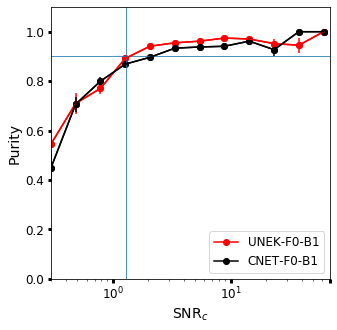

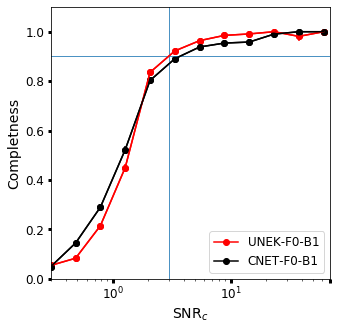

0

In [133]:
legend_loc = "best"

plot_metrics_snr_all([path_to_unek_stat_f0_b1, path_to_cnet_stat_f0_b1], legend_loc,
                     [f"UNEK-F0-B1", f"CNET-F0-B1"], 2,
                     vthreshold=[1.3, 3.0])

#### SBR plots

Same combinations as SNR


Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
1.62E-02, 4, 70, 238, 0.05, 0.03, 0.02, 0.01
2.64E-02, 6, 27, 225, 0.18, 0.07, 0.03, 0.01
4.28E-02, 26, 19, 335, 0.58, 0.07, 0.07, 0.01
6.95E-02, 36, 20, 478, 0.64, 0.06, 0.07, 0.01
1.13E-01, 110, 36, 637, 0.75, 0.04, 0.15, 0.01
1.83E-01, 239, 45, 699, 0.84, 0.02, 0.25, 0.01
2.98E-01, 415, 52, 590, 0.89, 0.01, 0.41, 0.02
4.83E-01, 653, 53, 390, 0.92, 0.01, 0.63, 0.01
7.85E-01, 815, 53, 190, 0.94, 0.01, 0.81, 0.01
1.27E+00, 903, 46, 73, 0.95, 0.01, 0.93, 0.01
2.07E+00, 747, 26, 46, 0.97, 0.01, 0.94, 0.01
3.36E+00, 443, 14, 25, 0.97, 0.01, 0.95, 0.01
5.46E+00, 266, 10, 14, 0.96, 0.01, 0.95, 0.01
8.86E+00, 114, 6, 4, 0.95, 0.02, 0.97, 0.02
1.44E+01, 58, 2, 1, 0.97, 0.02, 0.98, 0.02
2.34E+01, 39, 2, 1, 0.95, 0.03, 0.97, 0.02
3.79E+01, 19, 0, 0, 1.00, 0.00, 1.00, 0.00
6.16E+01, 4, 0, 0, 1.00, 0.00, 1.00, 0.00

Histogram Info

Bin, TP, FP, FN, Purity, Err_Pur, Completness, Err_Com
1.62E-02, 2, 51, 239, 0.04, 0.03, 0.01, 

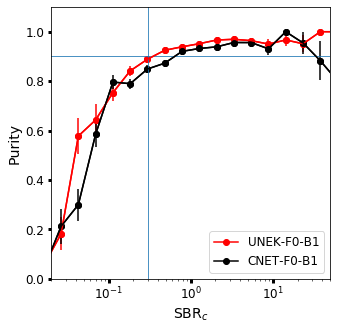

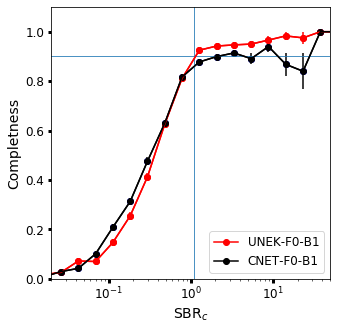

0

In [135]:
legend_loc = "lower right"

plot_metrics_sbr_all([path_to_unek_stat_f0_b1, path_to_cnet_stat_f0_b1], legend_loc, 
                     [f"UNEK-F0-B1", f"CNET-F0-B1"], 2,
                     vthreshold=[0.3, 1.1])

####  Notice that in this case TP + FN is not equal for UNEK and CNET since the value of SBR indeed depends on the position of the predicted sources, which are not equal in both cases

#### For CNET, he last two bins contain less tp events but the completness is equal to 1, so no error. While in the third to last bin (completness = 0.84) the number of true positives is lower than previous bins, thus the error is higher

In [138]:
print("%.2f"%error_function(21,4))

0.07


In [139]:
print("%.2f"%error_function(46,7))

0.05
